In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/goldenretrieveropennew2.jpg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/Golden-Retriever-Pair-3.jpg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/golden-retriever-857423.jpeg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/golden-retriever-456920.jpg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/golden_retriever_cadells.jpg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/golden-retriever-550511.jpg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/golden-retriever-0455.jpg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/A44D58A1-6606-4639-A5CC-E495742F6600.jpeg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/golden-retriever-834969.jpeg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/retriever-golden-szczeniak-2.jpeg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/22335-6317.jpg
/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever/

## 1. Import required packages : 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import pathlib

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten,Activation, BatchNormalization,MaxPooling2D
from tensorflow.keras import datasets, layers, models


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Visualizing Data : 

/opt/conda/lib/python3.10/site-packages/numpy/ma/core.py:4121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = compare(sdata, odata)


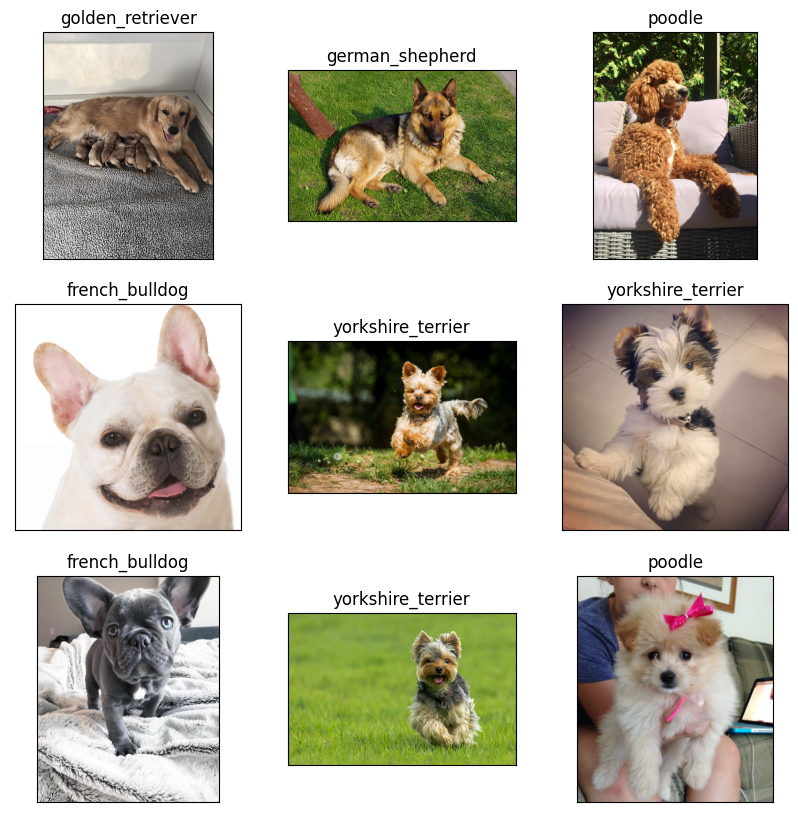

In [4]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

# set the path to the folder containing the species subfolders
path = "/kaggle/input/dogs-breed-dataset/dog_v1"

# get a list of all subdirectories (i.e., species folders) in the folder
species_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

# define the number of images to plot per row and column
num_rows = 3
num_cols = 3

# create a figure with a 3x3 grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# iterate over the subdirectories and randomly select an image from each
for i, species_folder in enumerate(species_folders):
    # get a list of all image filenames in the species folder
    image_files = [os.path.join(path, species_folder, f) for f in os.listdir(os.path.join(path, species_folder)) if f.endswith('.jpg')]
    
    # select a random image from the list
    random_image_file = random.choice(image_files)
    
    # load the image and its corresponding label
    image = imread(random_image_file)
    label = species_folder
    
    # calculate the subplot index based on the row and column position
    row = i // num_cols
    col = i % num_cols
    index = row * num_cols + col
    
    # plot the image and label in the corresponding subplot
    axes[row, col].imshow(image)
    axes[row, col].set_title(label)
    
    # remove the axes ticks and labels
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])
    
    # fill the remaining subplots in the row with additional images from the same folder
    for j in range(col+1, num_cols):
        if len(image_files) > 1:
            # select a different image from the folder
            while True:
                random_image_file = random.choice(image_files)
                if random_image_file != image_files[0]:
                    break
            image = imread(random_image_file)
            label = os.path.basename(os.path.dirname(random_image_file))
            axes[row, j].imshow(image)
            axes[row, j].set_title(label)
            axes[row, j].set_xticks([])
            axes[row, j].set_yticks([])
    
    # fill the remaining subplots in the column with additional images from the same folder
    for j in range(row+1, num_rows):
        if len(image_files) > j - row:
            # select a different image from the folder
            while True:
                random_image_file = random.choice(image_files)
                if random_image_file not in [axes[k, col].get_images()[0].get_array() for k in range(row)]:
                    break
            image = imread(random_image_file)
            label = os.path.basename(os.path.dirname(random_image_file))
            axes[j, col].imshow(image)
            axes[j, col].set_title(label)
            axes[j, col].set_xticks([])
            axes[j, col].set_yticks([])

plt.show()



## 3.Loading  Dataset and doing Data Augmentation 

In [6]:
## Data Augmentation : 
from keras.preprocessing.image import ImageDataGenerator

# Define the directory containing the images
data_dir = "/kaggle/input/dogs-breed-dataset/dog_v1"

# Define the parameters for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1./255
)

# Define the training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 826 images belonging to 5 classes.
Found 204 images belonging to 5 classes.


In [7]:
for images, labels in train_generator:
    # Access the first batch of images and labels
    first_batch_images = images
    first_batch_labels = labels
    break

# Print the shape of the first batch of images and labels
print("First batch of images shape:", first_batch_images.shape)
print("First batch of labels shape:", first_batch_labels.shape)


First batch of images shape: (32, 256, 256, 3)
First batch of labels shape: (32, 5)


In [8]:
### Printing Labels
train_generator.class_indices

{'french_bulldog': 0,
 'german_shepherd': 1,
 'golden_retriever': 2,
 'poodle': 3,
 'yorkshire_terrier': 4}

## 4. CNN Baseline Model  : 

In [9]:
model = Sequential()

# Add convolutional layers
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
# Add fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))




In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)     

In [10]:
### Warming up the Learning rate 

from keras.callbacks import Callback
import math

class LearningRateWarmupCallback(Callback):
    def __init__(self, warmup_batches, init_lr, verbose=0):
        super(LearningRateWarmupCallback, self).__init__()
        self.warmup_batches = warmup_batches
        self.init_lr = init_lr
        self.verbose = verbose

    def on_train_batch_begin(self, batch, logs=None):
        if batch < self.warmup_batches:
            lr = self.init_lr * (batch + 1) / self.warmup_batches
            if self.verbose > 0:
                print(f'Batch {batch}: Learning rate = {lr}')
            self.model.optimizer.lr = lr


In [11]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)


history = model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Define the number of epochs to train the model
epochs = 50

# Define the warmup period and initial learning rate
warmup_batches = 5
init_lr = 0.001

# Define the learning rate warmup callback
lr_callback = LearningRateWarmupCallback(warmup_batches, init_lr)

# Train the model using the fit method
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stop]
)



Epoch 1/50


2023-05-08 12:40:13.017552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 3/26 [==>...........................] - ETA: 14s - loss: 3.7794 - accuracy: 0.2083

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 4/26 [===>..........................] - ETA: 24s - loss: 3.7620 - accuracy: 0.2031

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


26/26 [==============================] - 71s 2s/step - loss: 1.9555 - accuracy: 0.2131 - val_loss: 1.6000 - val_accuracy: 0.3186
Epoch 2/50
26/26 [==============================] - 48s 2s/step - loss: 1.5835 - accuracy: 0.2663 - val_loss: 1.5785 - val_accuracy: 0.2500
Epoch 3/50
26/26 [==============================] - 47s 2s/step - loss: 1.5723 - accuracy: 0.2857 - val_loss: 1.5510 - val_accuracy: 0.2549
Epoch 4/50
26/26 [==============================] - 47s 2s/step - loss: 1.5408 - accuracy: 0.2772 - val_loss: 1.5407 - val_accuracy: 0.3137
Epoch 5/50
26/26 [==============================] - 48s 2s/step - loss: 1.5105 - accuracy: 0.3208 - val_loss: 1.5132 - val_accuracy: 0.3088
Epoch 6/50
26/26 [==============================] - 47s 2s/step - loss: 1.4777 - accuracy: 0.3547 - val_loss: 1.5034 - val_accuracy: 0.3284
Epoch 7/50
26/26 [==============================] - 47s 2s/step - loss: 1.4583 - accuracy: 0.3644 - val_loss: 1.4496 - val_accuracy: 0.3627
Epoch 8/50
26/26 [=============

### 4.1 Plotting results of baseline Model: 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score

def calculate_metrics(model, data_generator,history):
    # Get the true labels and predicted probabilities for the data generator
    Y_true = []
    Y_pred_probs = []
    for i in range(len(data_generator)):
        batch = data_generator[i]
        Y_true.extend(batch[1])
        Y_pred_probs.extend(model.predict(batch[0]))
    Y_true = np.argmax(Y_true, axis=1)
    Y_pred = np.argmax(Y_pred_probs, axis=1)
    
    # Get the class names from the data generator
    class_names = list(data_generator.class_indices.keys())
    
    # Calculate the metrics
    accuracy = accuracy_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred, average='weighted', labels=np.unique(Y_pred))
    precision = precision_score(Y_true, Y_pred, average='weighted', labels=np.unique(Y_pred))
    recall = recall_score(Y_true, Y_pred, average='weighted', labels=np.unique(Y_pred))
    
    # Plot the confusion matrix
    cm = confusion_matrix(Y_true, Y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    
    print("Accuracy: {:.4f}".format(accuracy))
    print("F1 Score: {:.4f}".format(f1))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    
    # Plot the training and validation loss
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot the accuracy over epochs
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'])
    plt.show()
    


    
    


1/1 [==============================] - 0s 31ms/step
Accuracy: 0.4363
F1 Score: 0.4231
Precision: 0.4315
Recall: 0.4363


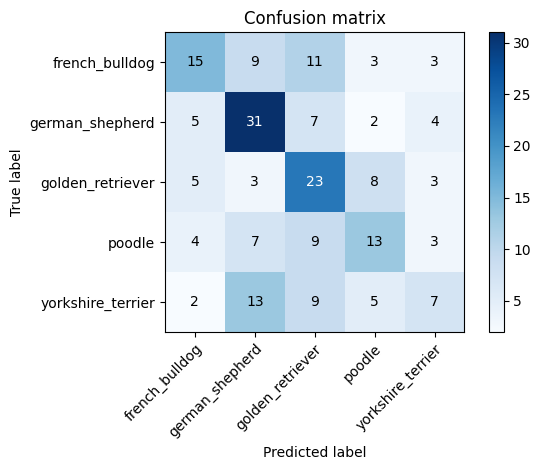

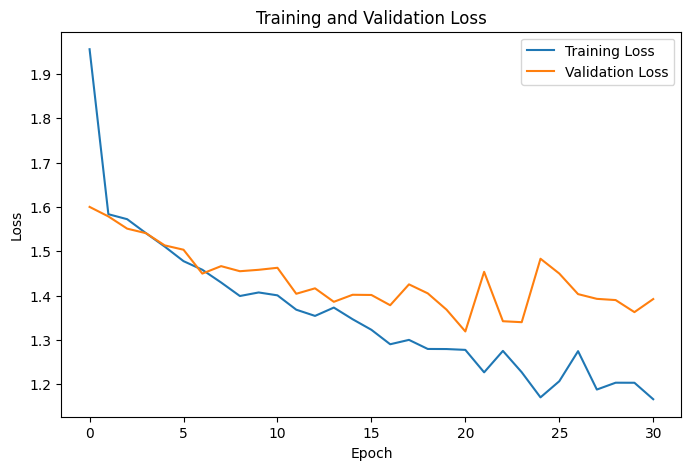

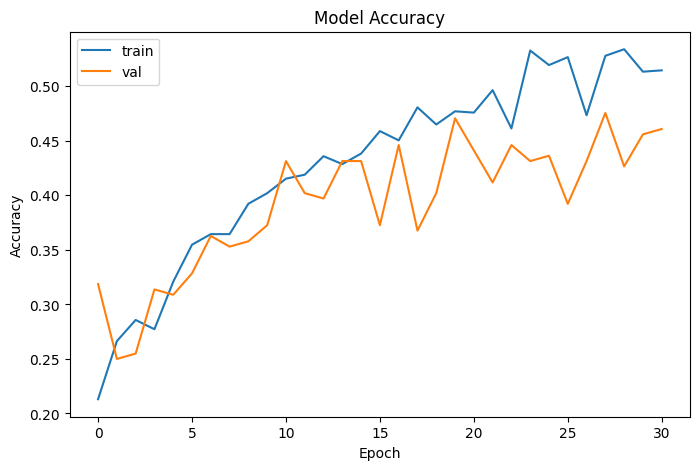

In [28]:
calculate_metrics(model=model, data_generator=validation_generator,history=history)

## 5. Finetuning ResNET : 

In [29]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False
    
    
# Define the parameters for data augmentation
data_dir = "/kaggle/input/dogs-breed-dataset/dog_v1"
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1./255
)

# Define the training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Add new classification layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(5, activation='softmax')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Define Early Stopping : 
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

# Train the model
history = model.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    validation_steps=validation_generator.n//validation_generator.batch_size
)




94765736/94765736 [==============================] - 0s 0us/step
Found 826 images belonging to 5 classes.
Found 204 images belonging to 5 classes.


/tmp/ipykernel_31/197657505.py:63: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
 8/25 [========>.....................] - ETA: 22s - loss: 12.9165 - accuracy: 0.2148

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 64s 2s/step - loss: 5.4824 - accuracy: 0.1902 - val_loss: 2.2326 - val_accuracy: 0.1823
Epoch 2/10
25/25 [==============================] - 57s 2s/step - loss: 1.6817 - accuracy: 0.1851 - val_loss: 1.6091 - val_accuracy: 0.2396
Epoch 3/10
25/25 [==============================] - 56s 2s/step - loss: 1.7105 - accuracy: 0.2355 - val_loss: 1.6086 - val_accuracy: 0.2344
Epoch 4/10
25/25 [==============================] - 56s 2s/step - loss: 1.6886 - accuracy: 0.2418 - val_loss: 1.6082 - val_accuracy: 0.2292
Epoch 5/10
25/25 [==============================] - 56s 2s/step - loss: 1.7705 - accuracy: 0.2494 - val_loss: 1.6081 - val_accuracy: 0.2396
Epoch 6/10
25/25 [==============================] - 57s 2s/step - loss: 1.6714 - accuracy: 0.2380 - val_loss: 1.6077 - val_accuracy: 0.2292
Epoch 7/10
25/25 [==============================] - 56s 2s/step - loss: 1.7513 - accuracy: 0.2355 - val_loss: 1.6070 - val_accuracy: 0.2344
Epoch 8/10
25/25 [=============

### 5.1 Plotting ResNET results

1/1 [==============================] - 2s 2s/step
Accuracy: 0.2402
F1 Score: 0.3874
Precision: 0.2402
Recall: 1.0000


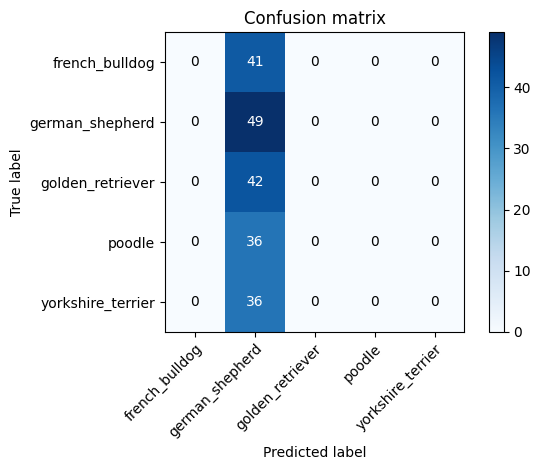

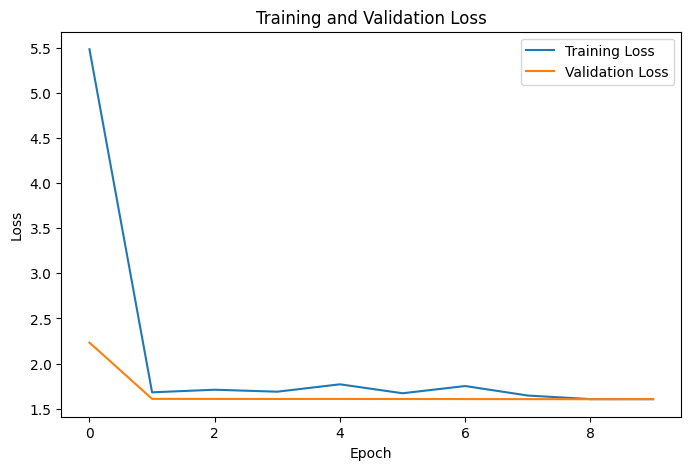

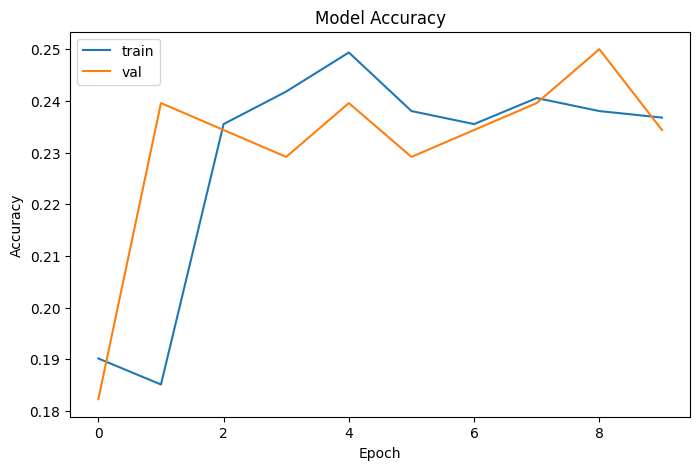

In [31]:
calculate_metrics(model=model, data_generator=validation_generator,history=history)

## 6. Finetuning MobileNET

In [32]:
from keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Load the pre-trained InceptionNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False
data_dir = "/kaggle/input/dogs-breed-dataset/dog_v1"
# Define the parameters for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1./255
)

# Define the training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

## Define Early Stopping : 
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    verbose=1)



17225924/17225924 [==============================] - 0s 0us/step
Found 826 images belonging to 5 classes.
Found 204 images belonging to 5 classes.
Epoch 1/10
 8/26 [========>.....................] - ETA: 21s - loss: 1.3060 - accuracy: 0.4560

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


21/26 [=======================>......] - ETA: 6s - loss: 0.7490 - accuracy: 0.7297

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


26/26 [==============================] - 51s 2s/step - loss: 0.6575 - accuracy: 0.7676 - val_loss: 0.1148 - val_accuracy: 0.9706
Epoch 2/10
26/26 [==============================] - 46s 2s/step - loss: 0.1636 - accuracy: 0.9516 - val_loss: 0.0662 - val_accuracy: 0.9804
Epoch 3/10
26/26 [==============================] - 46s 2s/step - loss: 0.0968 - accuracy: 0.9746 - val_loss: 0.0404 - val_accuracy: 0.9951
Epoch 4/10
26/26 [==============================] - 47s 2s/step - loss: 0.0820 - accuracy: 0.9806 - val_loss: 0.0455 - val_accuracy: 0.9853
Epoch 5/10
26/26 [==============================] - 47s 2s/step - loss: 0.0484 - accuracy: 0.9879 - val_loss: 0.0579 - val_accuracy: 0.9853
Epoch 6/10
26/26 [==============================] - 56s 2s/step - loss: 0.0631 - accuracy: 0.9746 - val_loss: 0.0493 - val_accuracy: 0.9755
Epoch 7/10
26/26 [==============================] - 48s 2s/step - loss: 0.0421 - accuracy: 0.9843 - val_loss: 0.0673 - val_accuracy: 0.9755
Epoch 8/10
26/26 [=============

### 6.1 Plotting MobileNET Results

1/1 [==============================] - 0s 29ms/step
Accuracy: 0.9804
F1 Score: 0.9804
Precision: 0.9812
Recall: 0.9804


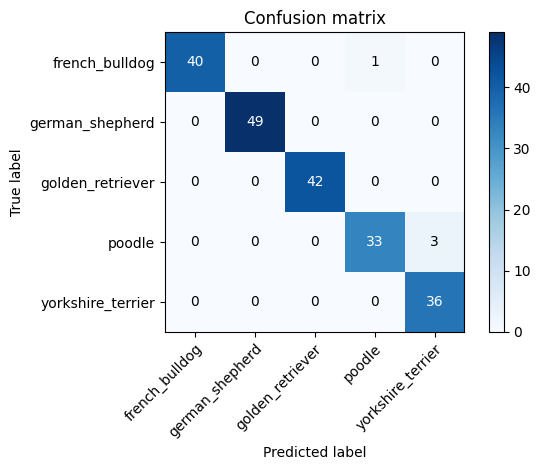

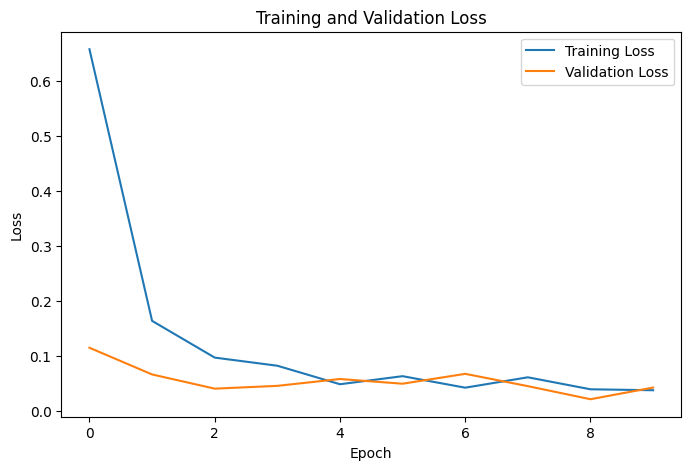

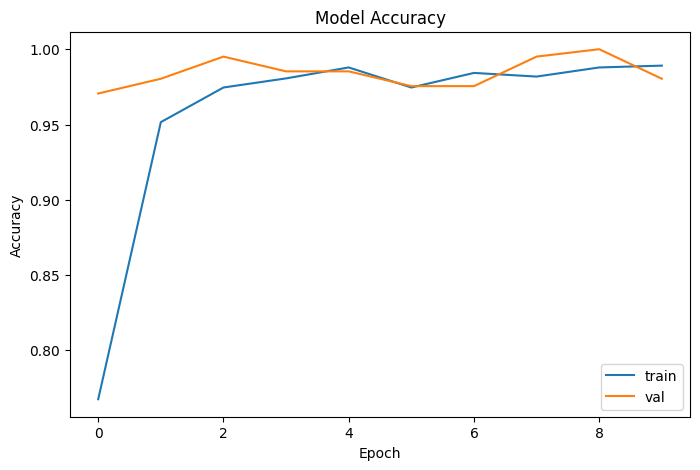

In [34]:
calculate_metrics(model=model, data_generator=validation_generator,history=history)

## 7. DenseNET


In [5]:
from keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Load the pre-trained InceptionNet model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False
data_dir = "/kaggle/input/dogs-breed-dataset/dog_v1"
# Define the parameters for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1./255
)

# Define the training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

## Define Early Stopping : 
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    verbose=1)

74836368/74836368 [==============================] - 0s 0us/step
Found 826 images belonging to 5 classes.
Found 204 images belonging to 5 classes.
Epoch 1/10
 3/26 [==>...........................] - ETA: 32s - loss: 1.4619 - accuracy: 0.4271

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/26 [=================>............] - ETA: 19s - loss: 0.7200 - accuracy: 0.7754

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


26/26 [==============================] - 99s 3s/step - loss: 0.5111 - accuracy: 0.8438 - val_loss: 0.1107 - val_accuracy: 0.9755
Epoch 2/10
26/26 [==============================] - 50s 2s/step - loss: 0.1105 - accuracy: 0.9685 - val_loss: 0.0602 - val_accuracy: 0.9902
Epoch 3/10
26/26 [==============================] - 48s 2s/step - loss: 0.0743 - accuracy: 0.9734 - val_loss: 0.0400 - val_accuracy: 0.9951
Epoch 4/10
26/26 [==============================] - 49s 2s/step - loss: 0.0528 - accuracy: 0.9867 - val_loss: 0.0407 - val_accuracy: 0.9951
Epoch 5/10
26/26 [==============================] - 49s 2s/step - loss: 0.0455 - accuracy: 0.9855 - val_loss: 0.0567 - val_accuracy: 0.9902
Epoch 6/10
26/26 [==============================] - 49s 2s/step - loss: 0.0377 - accuracy: 0.9891 - val_loss: 0.0341 - val_accuracy: 0.9951
Epoch 7/10
26/26 [==============================] - 49s 2s/step - loss: 0.0313 - accuracy: 0.9855 - val_loss: 0.0458 - val_accuracy: 0.9853
Epoch 8/10
26/26 [=============

### Plotting DenseNET results

1/1 [==============================] - 3s 3s/step
Accuracy: 0.9951
F1 Score: 0.9951
Precision: 0.9952
Recall: 0.9951


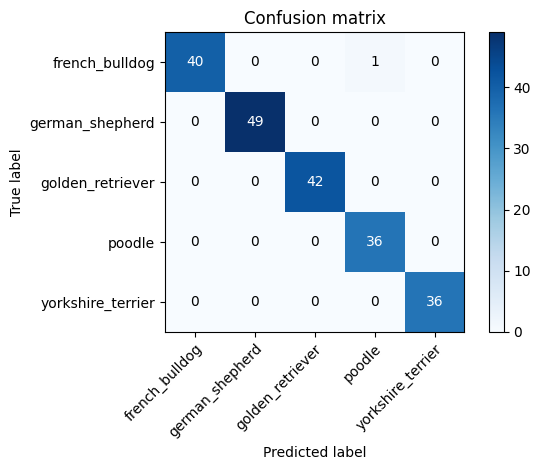

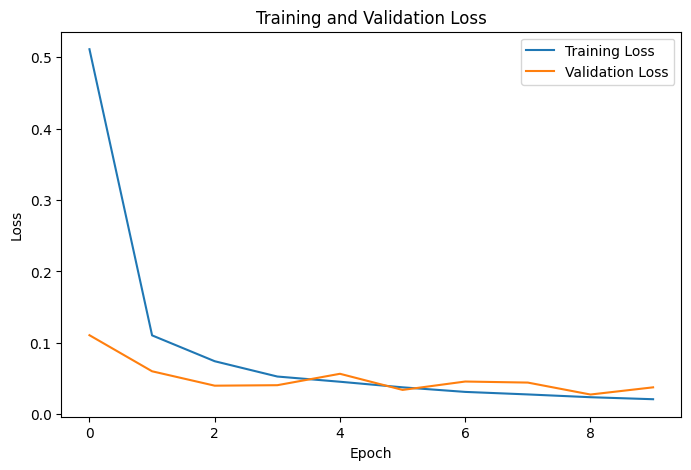

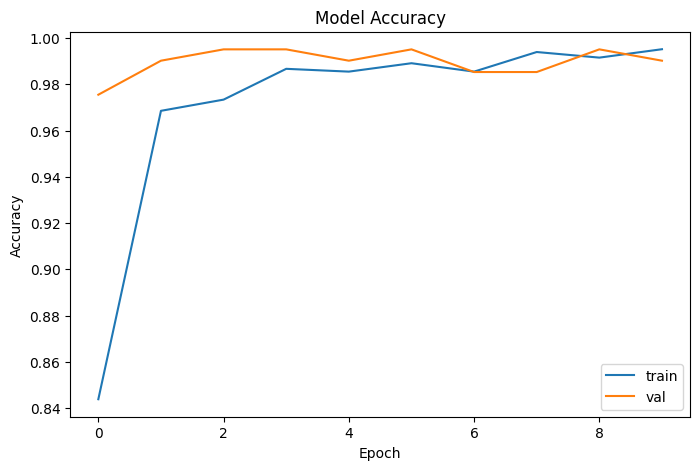

In [6]:
calculate_metrics(model=model, data_generator=validation_generator,history=history)

## 8 Fine Tuning InceptionNET

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Load the pre-trained InceptionNet model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False
data_dir = "/kaggle/input/dogs-breed-dataset/dog_v1"
# Define the parameters for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1./255
)

# Define the training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

## Define Early Stopping : 
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    verbose=1)





Found 826 images belonging to 5 classes.
Found 204 images belonging to 5 classes.
Epoch 1/10
10/26 [==========>...................] - ETA: 25s - loss: 0.6399 - accuracy: 0.7803

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


24/26 [==========================>...] - ETA: 3s - loss: 0.3453 - accuracy: 0.8898

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


26/26 [==============================] - 84s 3s/step - loss: 0.3253 - accuracy: 0.8959 - val_loss: 0.0798 - val_accuracy: 0.9706
Epoch 2/10
26/26 [==============================] - 50s 2s/step - loss: 0.0823 - accuracy: 0.9734 - val_loss: 0.0426 - val_accuracy: 0.9853
Epoch 3/10
26/26 [==============================] - 50s 2s/step - loss: 0.0552 - accuracy: 0.9806 - val_loss: 0.0433 - val_accuracy: 0.9853
Epoch 4/10
26/26 [==============================] - 58s 2s/step - loss: 0.0655 - accuracy: 0.9782 - val_loss: 0.1152 - val_accuracy: 0.9755
Epoch 5/10
26/26 [==============================] - 49s 2s/step - loss: 0.0642 - accuracy: 0.9831 - val_loss: 0.0699 - val_accuracy: 0.9804
Epoch 6/10
26/26 [==============================] - 50s 2s/step - loss: 0.0437 - accuracy: 0.9867 - val_loss: 0.0221 - val_accuracy: 0.9902
Epoch 7/10
26/26 [==============================] - 59s 2s/step - loss: 0.0393 - accuracy: 0.9879 - val_loss: 0.0401 - val_accuracy: 0.9853
Epoch 8/10
26/26 [=============

In [ ]:
### Saving the Model 
model.save("inception_net.h5")

### 7.1 Plotting InceptionNET results

1/1 [==============================] - 1s 1s/step
Accuracy: 0.9853
F1 Score: 0.9853
Precision: 0.9859
Recall: 0.9853


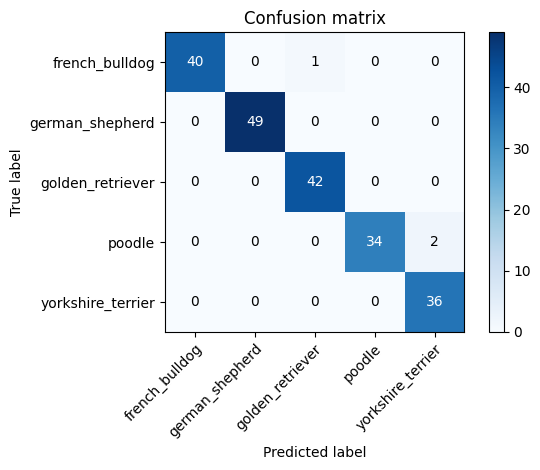

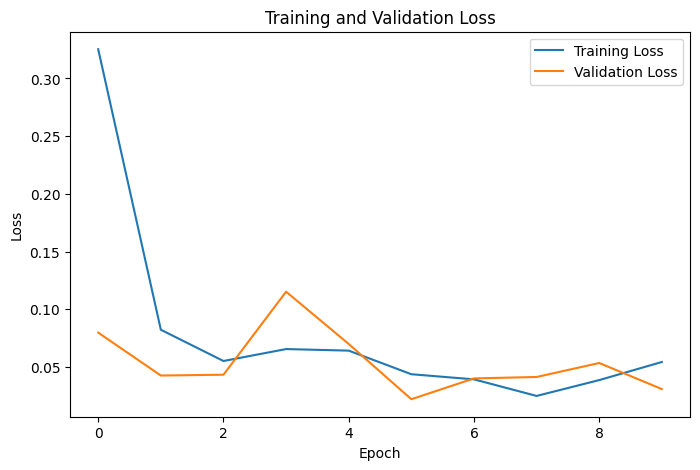

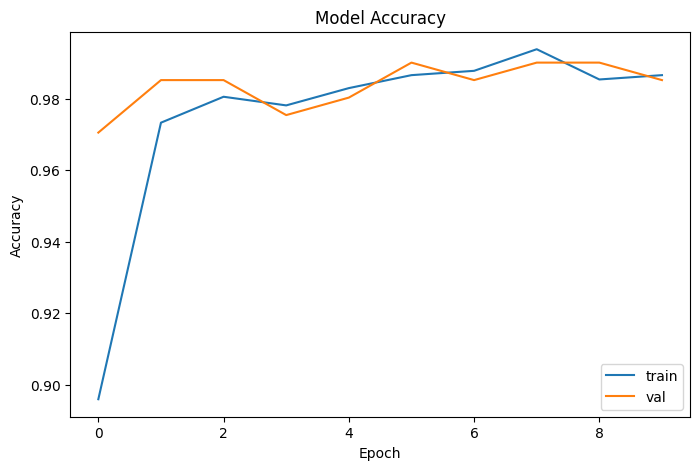

In [7]:
calculate_metrics(model=model, data_generator=validation_generator,history=history)

## 8. Plotting Predictions of InceptionNET

1/1 [==============================] - 0s 33ms/step


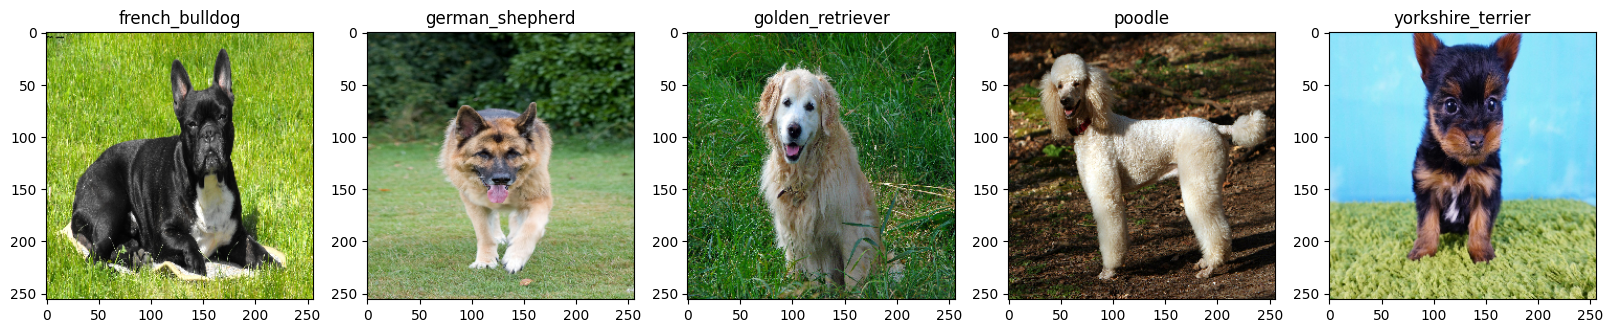

In [10]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Define the class names
class_names = list(train_generator.class_indices.keys())

# Define the paths to the test images for each class
class_paths = [
    "/kaggle/input/dogs-breed-dataset/dog_v1/french_bulldog",
    "/kaggle/input/dogs-breed-dataset/dog_v1/german_shepherd",
    "/kaggle/input/dogs-breed-dataset/dog_v1/golden_retriever",
    "/kaggle/input/dogs-breed-dataset/dog_v1/poodle",
    "/kaggle/input/dogs-breed-dataset/dog_v1/yorkshire_terrier"
]

# Create a list to store the images and their predicted class names
images_and_labels = []

# Load a random image from each class, make a prediction, and store the result
for i, class_path in enumerate(class_paths):
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    img = load_img(img_path, target_size=(256, 256))
    x = img_to_array(img)
    x = x / 255.
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    pred_class_id = np.argmax(pred[0])
    pred_class_name = class_names[pred_class_id]
    images_and_labels.append((img, pred_class_name))

# Plot the images with their predicted class names
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, (img, label) in enumerate(images_and_labels):
    axs[i].imshow(img)
    axs[i].set_title(label)
plt.show()
